##Instalação das bibliotecas


In [ ]:
pip install numpy matplotlib scipy requests  rasterstats

##BOLETIM DIÁRIO INTERPOLADO
Este script gera o mapa interpolado contínuo da chuva do período hidrológico das 07h às 07h  (24h)

Digite os prefixos das estações a serem excluídas (separados por vírgula), ou pressione Enter para continuar: 
Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


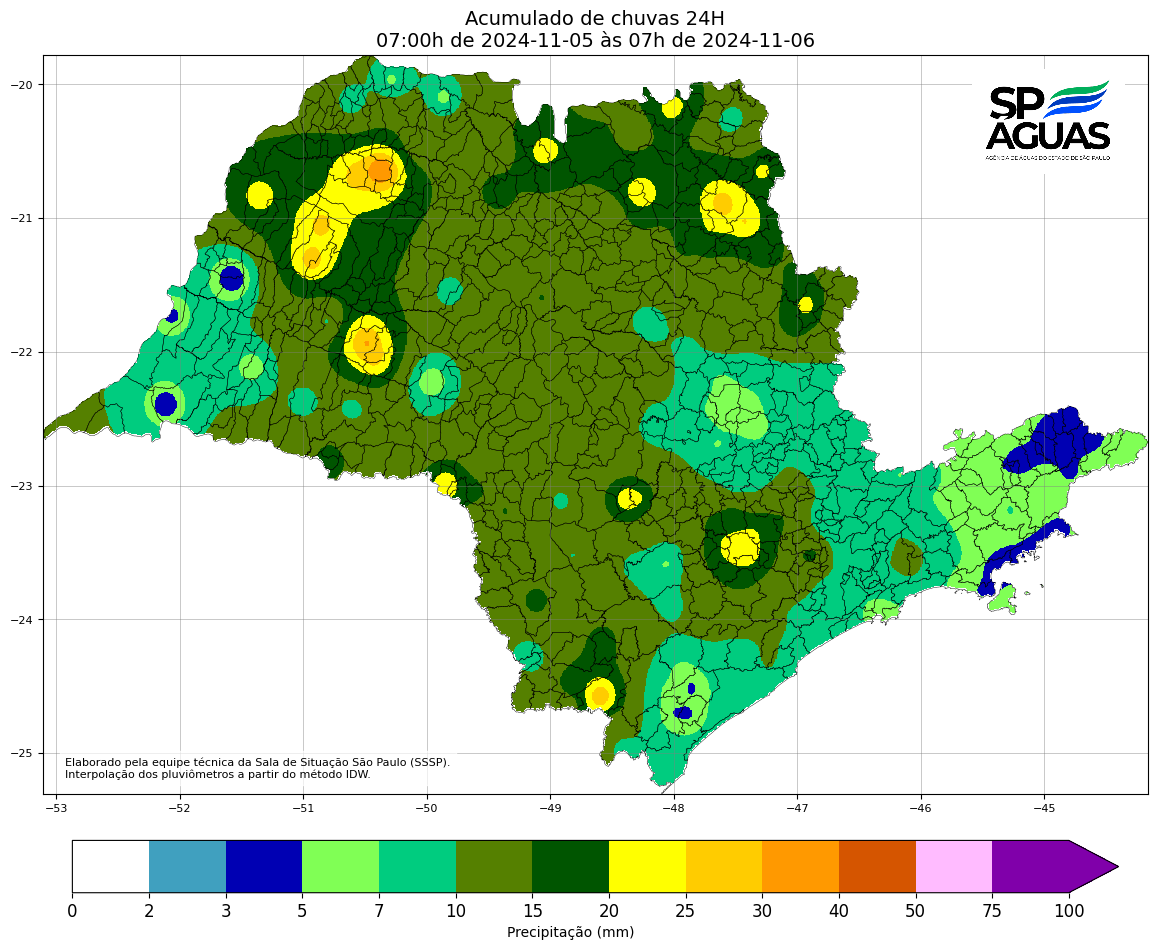

In [1]:
import geopandas as gpd
from osgeo import gdal, ogr, osr
import requests
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from datetime import datetime, timedelta
import os

# Perguntar ao usuário se deseja excluir alguma estação por prefixo
excluir_prefixos = input(
    "Digite os prefixos das estações a serem excluídas (separados por vírgula), ou pressione Enter para continuar: "
).strip()
excluir_prefixos = [prefix.strip() for prefix in excluir_prefixos.split(",")] if excluir_prefixos else []

def gerar_mapa_chuva(url, titulo, excluir_prefixos):
    # Carregando a fronteira do estado de São Paulo e criando um shapefile temporário
    sp_border = gpd.read_file('/content/drive/MyDrive/dados/DIV_MUN_IGC_SP_2021/DIV_MUN_SP_2021a.shp').to_crs(epsg=4326)
    minx, miny, maxx, maxy = sp_border.total_bounds

    sp_border_shapefile = "sp_border.shp"
    sp_border.to_file(sp_border_shapefile)

    # Obtendo dados da API
    response = requests.get(url)
    data = response.json()

    # Extraindo coordenadas e valores
    stations = [
        (item["prefix"], float(item["latitude"]), float(item["longitude"]), item["value"])
        for item in data["json"]
        if item["latitude"] and item["longitude"] and item["value"]
    ]

    # Filtrando estações
    filtered_stations = [
        (lat, lon, value)
        for prefix, lat, lon, value in stations
        if prefix not in excluir_prefixos
    ]

    if not filtered_stations:
        print("Erro: Não há dados válidos para interpolação após a exclusão.")
        return

    # Separando latitudes, longitudes e valores
    lats, longs, values = zip(*filtered_stations)

    # Salvando os pontos em um shapefile temporário
    shapefile_path = "temp_points.shp"
    driver = ogr.GetDriverByName("ESRI Shapefile")
    dataSource = driver.CreateDataSource(shapefile_path)
    layer = dataSource.CreateLayer("layer", geom_type=ogr.wkbPoint)

    # Adicionando valores de precipitação
    layer.CreateField(ogr.FieldDefn("value", ogr.OFTReal))
    for lat, lon, value in zip(lats, longs, values):
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(lon, lat)
        feature = ogr.Feature(layer.GetLayerDefn())
        feature.SetGeometry(point)
        feature.SetField("value", value)
        layer.CreateFeature(feature)
        feature = None

    dataSource = None


    """
    POWER
Igual a 2 é aconselhado na literatura

    SMOOTHING
Valores baixos (0.0 - 0.1): Mantêm os dados muito próximos ao valor real observado nas estações, o que resulta em uma interpolação mais "pontuda".
                            Isso é adequado se as estações estiverem muito próximas e os dados forem bastante consistentes.
Valores médios (0.2 - 1.0): Um valor de smoothing na faixa de 0.2 a 0.5 geralmente funciona bem para dados pluviométricos, especialmente quando as
                            estações estão razoavelmente espaçadas e você deseja suavizar gradualmente as variações. Esse intervalo ainda preserva o detalhe dos dados,
                            mas atenua picos extremos.
Valores altos (1.0 e acima): Resultam em uma interpolação muito mais suave, sendo útil apenas se você tiver uma rede de medição esparsa ou estiver mais interessado
                              na tendência geral do que nos detalhes locais.

    RADIUS
Valores em graus, o valor 0.09 equivale 10km

    """

    output_raster = "output_idw.tif"
    gdal.Grid(
        output_raster,
        shapefile_path,
        zfield="value",
        algorithm="invdist:power=2.0:smoothing=0.1:radius=10",
        outputBounds=(minx, miny, maxx, maxy),
        width=1000, height=1000,
    )

    if not os.path.exists(output_raster):
        print(f"Erro: O raster intermediário {output_raster} não foi criado.")
        return
    else:
        print(f"Raster intermediário {output_raster} criado com sucesso.")

    # Definindo sistema de coordenadas EPSG:4326 no raster
    raster = gdal.Open(output_raster, gdal.GA_Update)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    raster.SetProjection(srs.ExportToWkt())
    raster = None

    cropped_raster = "output_idw_cropped.tif"
    gdal.Warp(
        cropped_raster,
        output_raster,
        cutlineDSName=sp_border_shapefile,
        cropToCutline=True,
        dstNodata=np.nan,
    )

    # Verificação de criação do raster recortado
    if not os.path.exists(cropped_raster):
        print("Erro: O raster recortado não pôde ser criado.")
        return
    else:
        print("Raster recortado criado com sucesso.")

    # Plot do resultado
    fig, ax = plt.subplots(figsize=(18, 12))

    # Carregar e plotar o raster recortado
    raster = gdal.Open(cropped_raster)
    if raster is None:
        print("Erro: O raster recortado não pôde ser aberto.")
        return

    raster_data = raster.ReadAsArray()

    cmap = ListedColormap([
        "#ffffff00", "#0080aabf", "#0000B3", "#80FF55", "#00CC7F",
        "#558000", "#005500", "#FFFF00", "#FFCC00", "#FF9900",
        "#D55500", "#FFBBFF", "#FF2B80", "#8000AA"
    ])

    bounds = [0, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100]
    norm = BoundaryNorm(bounds, cmap.N)


    img = ax.imshow(raster_data, cmap=cmap, extent=(minx, maxx, miny, maxy), norm=norm)

    sp_border.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.3)


    cbar = fig.colorbar(img, ax=ax, orientation="horizontal", label="Precipitação (mm)", shrink=0.75, pad=0.05, extend='max')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([str(b) for b in bounds])
    cbar.ax.tick_params(labelsize=12)


    logo_path = "/content/drive/MyDrive/dados/logo.png"
    if os.path.exists(logo_path):

      logo = Image.open(logo_path)
      imagebox = OffsetImage(logo, zoom=0.2)

      ab = AnnotationBbox(
          imagebox,
          (0.91, 0.91),
          xycoords='axes fraction',
          frameon=True,
          bboxprops=dict(facecolor="white", edgecolor="none")
      )
      ax.add_artist(ab)
    else:
        print("Aviso: O logo não foi encontrado e não será exibido.")

    annotation_text = (
        "Elaborado pela equipe técnica da Sala de Situação São Paulo (SSSP).\n"
        "Interpolação dos pluviômetros a partir do método IDW."
    )

    ax.annotate(
        annotation_text, xy=(0.02, 0.02), xycoords='axes fraction',
        fontsize=8, ha='left', va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='white')
    )

    ax.set_title(f'{titulo}', fontsize=14)
    ax.grid(which='both', linestyle='-', linewidth=0.5, color='gray', alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=8)

    plt.savefig(titulo, dpi=300, bbox_inches="tight")

    plt.show()


hoje = datetime.now()
hoje_format = hoje.strftime('%Y-%m-%d')

ontem = hoje - timedelta(days=1)
ontem_format = ontem.strftime('%Y-%m-%d')


intervalos = [
    (f'https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=24&from_date={hoje_format}T07%3A00&show_all=true', f"Acumulado de chuvas 24H\n07:00h de {ontem_format} às 07h de {hoje_format}")

]


for url, titulo in intervalos:
    gerar_mapa_chuva(url, titulo, excluir_prefixos)



## BOLETIM DIÁRIO AGREGADO POR MUNICÍPIO
Este script gera um mapa da chuva interpolada, agregada por município. O usuário pode escolher o método estatístico para agregação.

Escolha a estatística para o cálculo de precipitação (max, mean, median): max


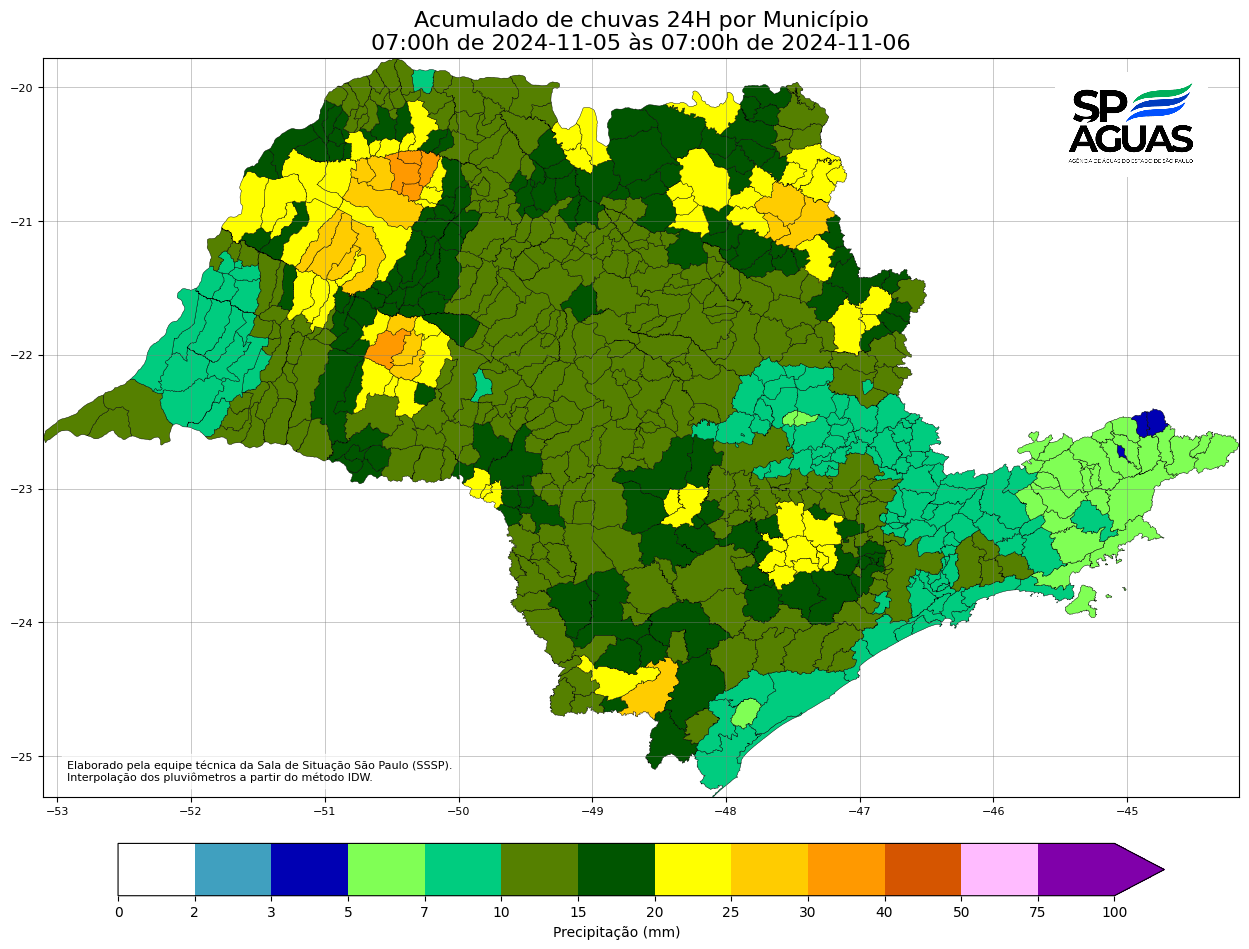

In [2]:
import geopandas as gpd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

def calcular_estatistica_por_municipio(raster_path, municipios_shapefile, estatistica="max"):
    # Carregar o shapefile de municípios
    municipios = gpd.read_file(municipios_shapefile).to_crs(epsg=4326)

    # Calcular a estatística de precipitação por município usando zonal_stats
    stats = zonal_stats(municipios, raster_path, stats=[estatistica], geojson_out=True)

    # Transformar o resultado em um GeoDataFrame
    municipios_stats = gpd.GeoDataFrame.from_features(stats)

    # Renomear a coluna para refletir a estatística escolhida
    municipios_stats = municipios_stats.rename(columns={estatistica: f"{estatistica}_precipitation"})

    return municipios_stats

def plotar_mapa_por_municipio(municipios_stats, titulo):

    sp_border = gpd.read_file('/content/drive/MyDrive/dados/DIV_MUN_IGC_SP_2021/DIV_MUN_SP_2021a.shp').to_crs(epsg=4326)
    minx, miny, maxx, maxy = sp_border.total_bounds

    # Definir os limites e o cmap para o colorbar
    bounds = [0, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100]
    cmap = ListedColormap([
        "#ffffff00", "#0080aabf", "#0000B3", "#80FF55", "#00CC7F",
        "#558000", "#005500", "#FFFF00", "#FFCC00", "#FF9900",
        "#D55500", "#FFBBFF", "#FF2B80", "#8000AA"
    ])
    norm = BoundaryNorm(bounds, cmap.N)

    # Plotar o mapa dos municípios com a estatística de precipitação
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Identificar o nome da coluna da estatística
    estatistica_coluna = [col for col in municipios_stats.columns if "_precipitation" in col][0]

    municipios_stats.plot(
        column=estatistica_coluna,
        cmap=cmap,
        linewidth=0.3,
        edgecolor="black",
        legend=False,
        ax=ax,
        norm=norm
    )

    # Adicionar o colorbar manualmente
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", label="Precipitação (mm)", shrink=0.75, pad=0.05, extend='max')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([str(b) for b in bounds])

    ax.set_title(titulo, fontsize=16)
    ax.grid(which='both', linestyle='-', linewidth=0.5, color='gray', alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=8)
    logo_path = "/content/drive/MyDrive/dados/logo.png"

    if os.path.exists(logo_path):
        logo = Image.open(logo_path)
        imagebox = OffsetImage(logo, zoom=0.2)
        ab = AnnotationBbox(
            imagebox,
            (0.91, 0.91),
            xycoords='axes fraction',
            frameon=True,
            bboxprops=dict(facecolor="white", edgecolor="none")
        )
        ax.add_artist(ab)
    else:
        print("Aviso: O logo não foi encontrado e não será exibido.")

    annotation_text = (
        "Elaborado pela equipe técnica da Sala de Situação São Paulo (SSSP).\n"
        "Interpolação dos pluviômetros a partir do método IDW."
    )

    ax.annotate(
        annotation_text, xy=(0.02, 0.02), xycoords='axes fraction',
        fontsize=8, ha='left', va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='white')
    )

    plt.savefig(titulo, dpi=300, bbox_inches="tight")
    plt.show()

# Caminhos para o raster e shapefile dos municípios
cropped_raster = "output_idw_cropped.tif"
municipios_shapefile = '/content/drive/MyDrive/dados/DIV_MUN_IGC_SP_2021/DIV_MUN_SP_2021a.shp'

# Solicitar a escolha da estatística ao usuário
estatistica_desejada = input("Escolha a estatística para o cálculo de precipitação (max, mean, median): ").strip().lower()
while estatistica_desejada not in ["max", "mean", "median"]:
    print("Opção inválida. Escolha entre 'max', 'mean' ou 'median'.")
    estatistica_desejada = input("Escolha a estatística para o cálculo de precipitação (max, mean, median): ").strip().lower()

# Calcular a estatística de precipitação por município
municipios_stats = calcular_estatistica_por_municipio(cropped_raster, municipios_shapefile, estatistica=estatistica_desejada)

# Plotar o mapa da estatística de precipitação por município
titulo_mapa = f"Acumulado de chuvas 24H por Município\n07:00h de {ontem_format} às 07:00h de {hoje_format}"
plotar_mapa_por_municipio(municipios_stats, titulo_mapa)


##GABINETE DE CRISE
Algoritmo que roda todos os intervalos de tempo do SIBH

Digite os prefixos das estações a serem excluídas (separados por vírgula), ou pressione Enter para continuar: 
Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


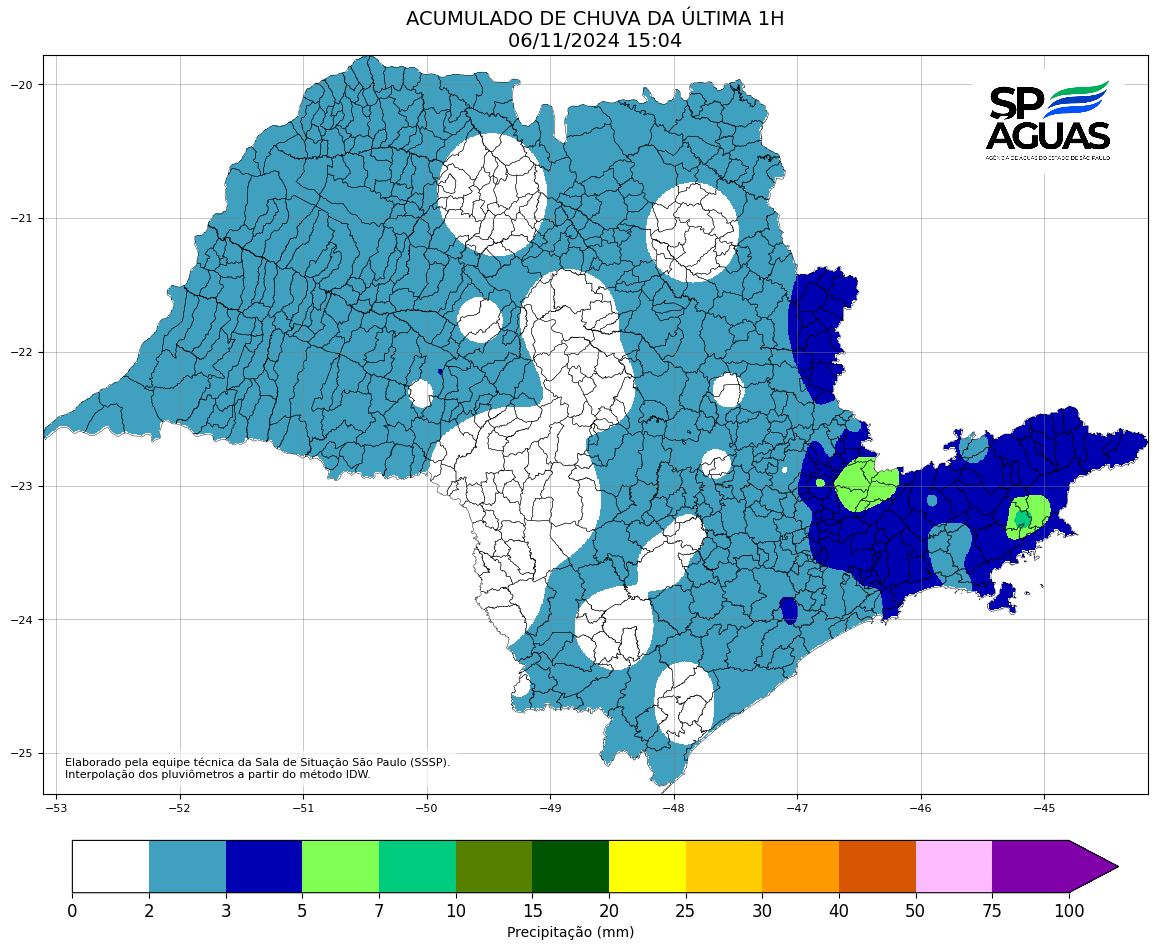

Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


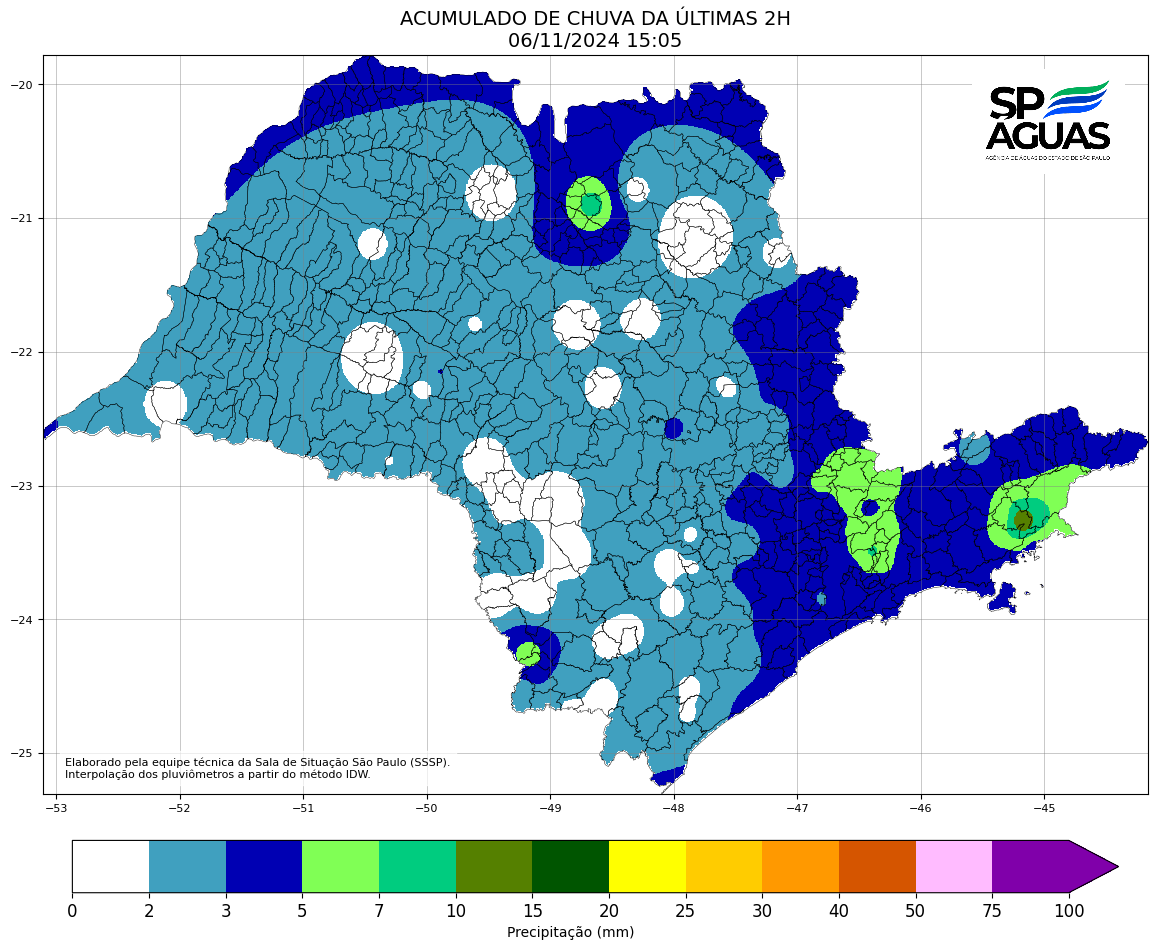

Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


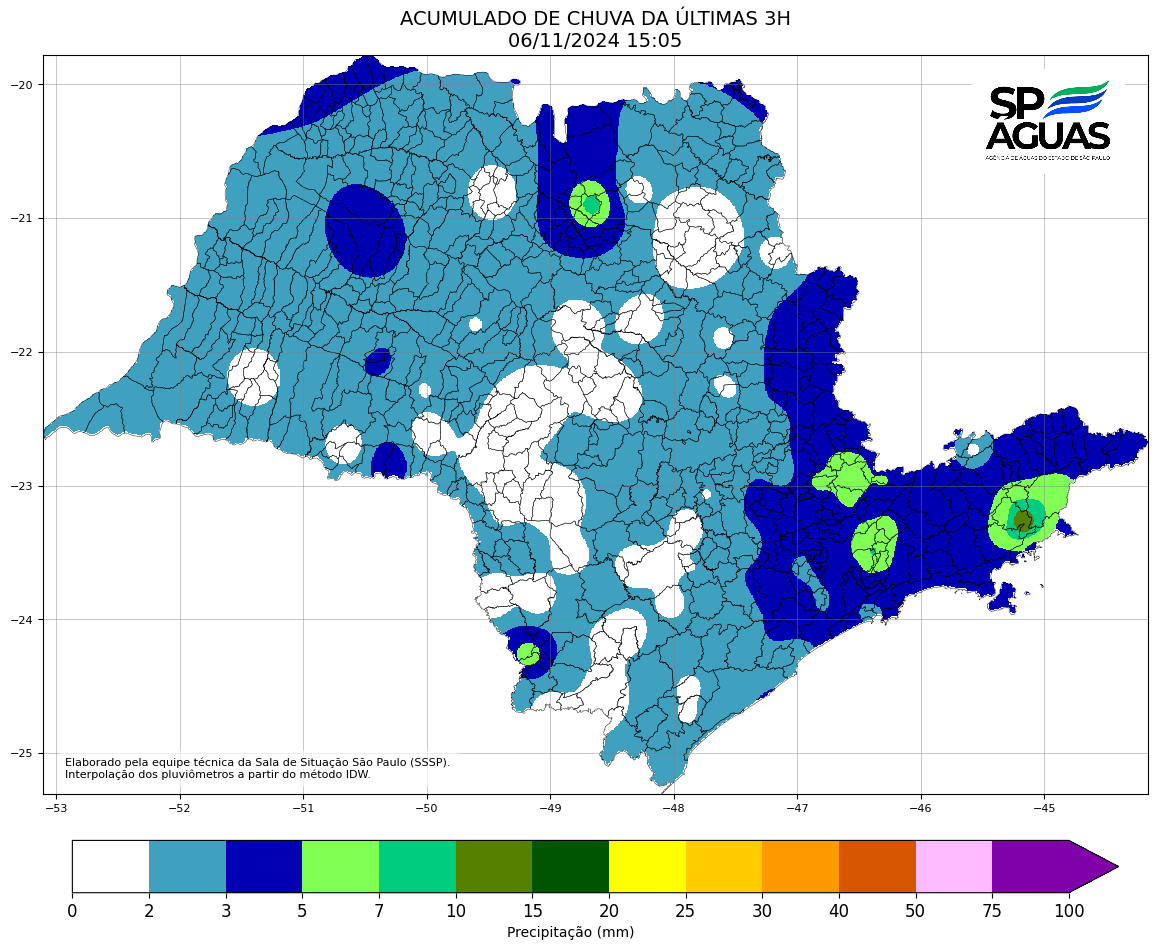

Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


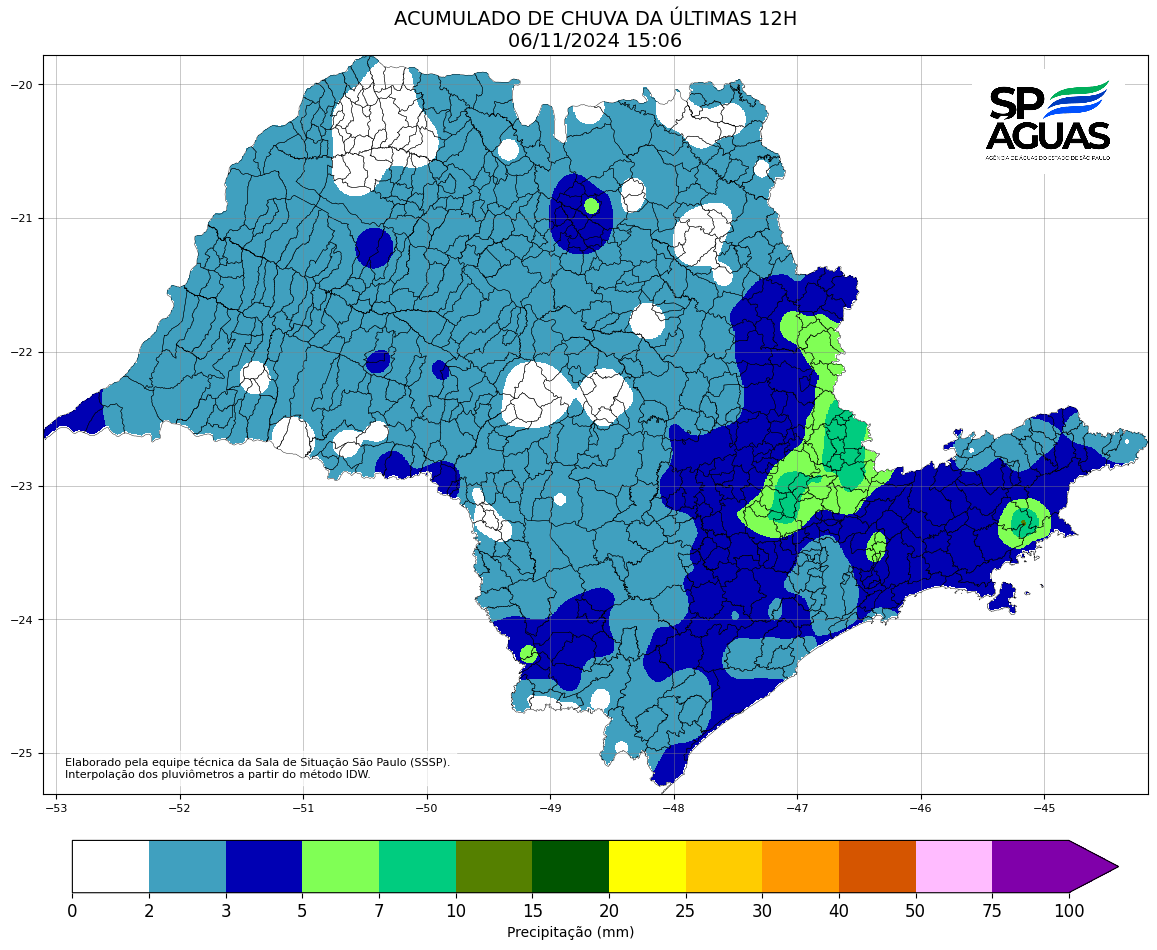

Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


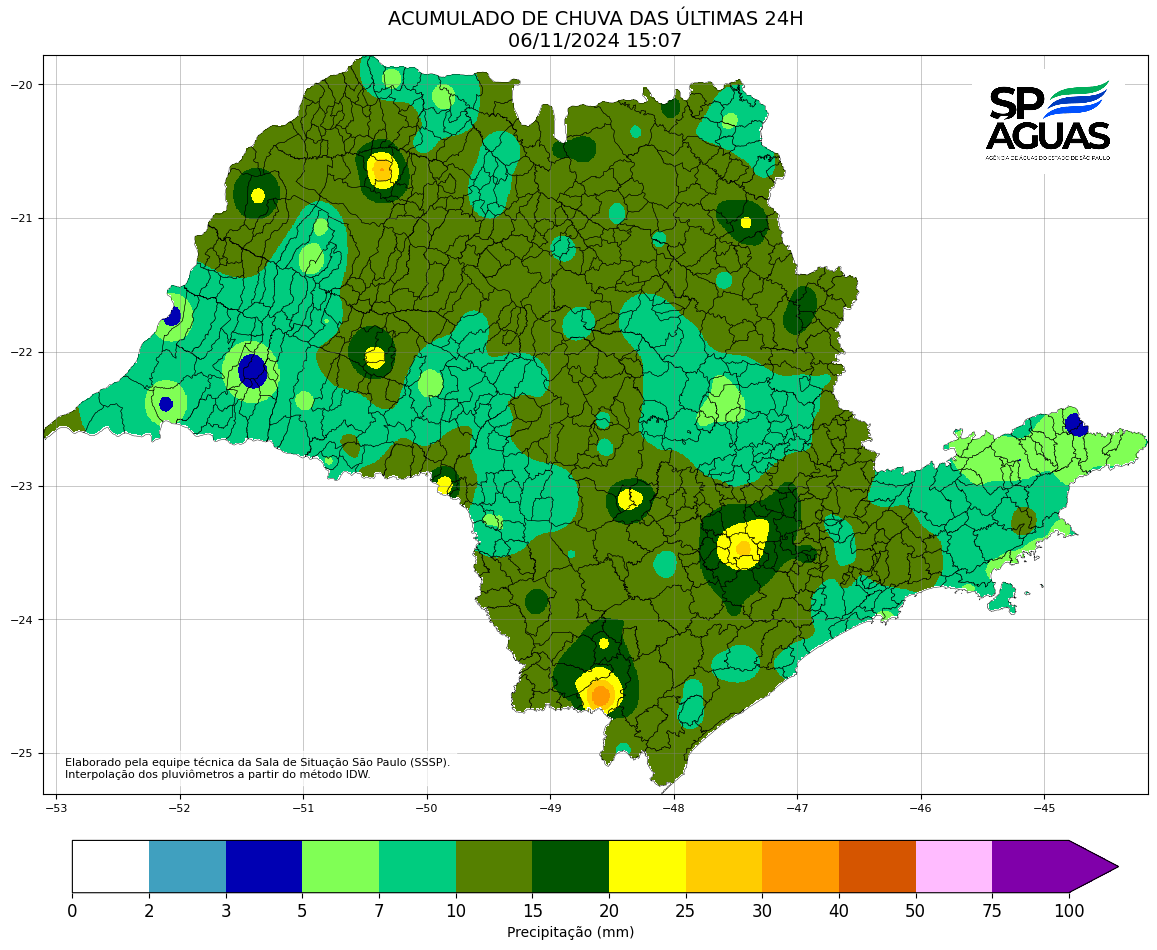

Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


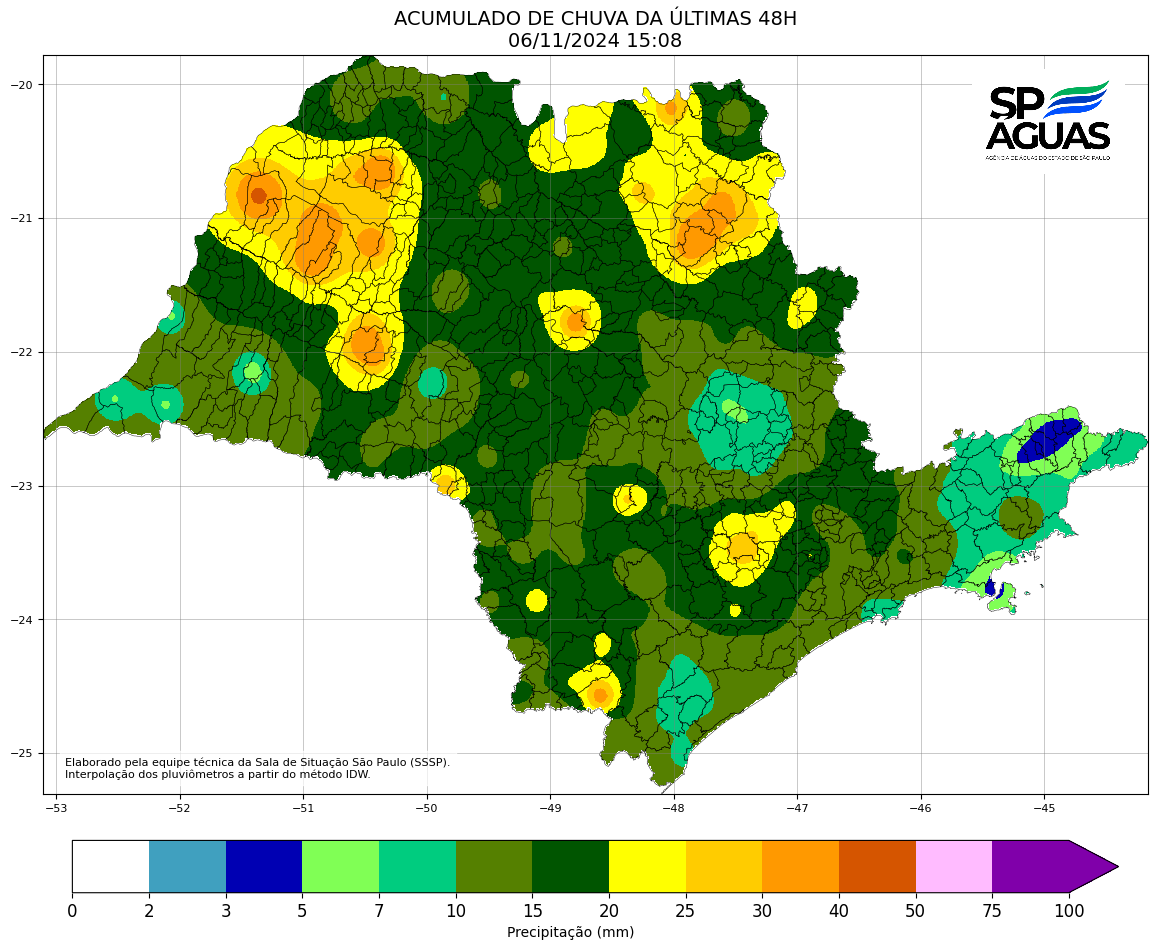

Raster intermediário output_idw.tif criado com sucesso.
Raster recortado criado com sucesso.


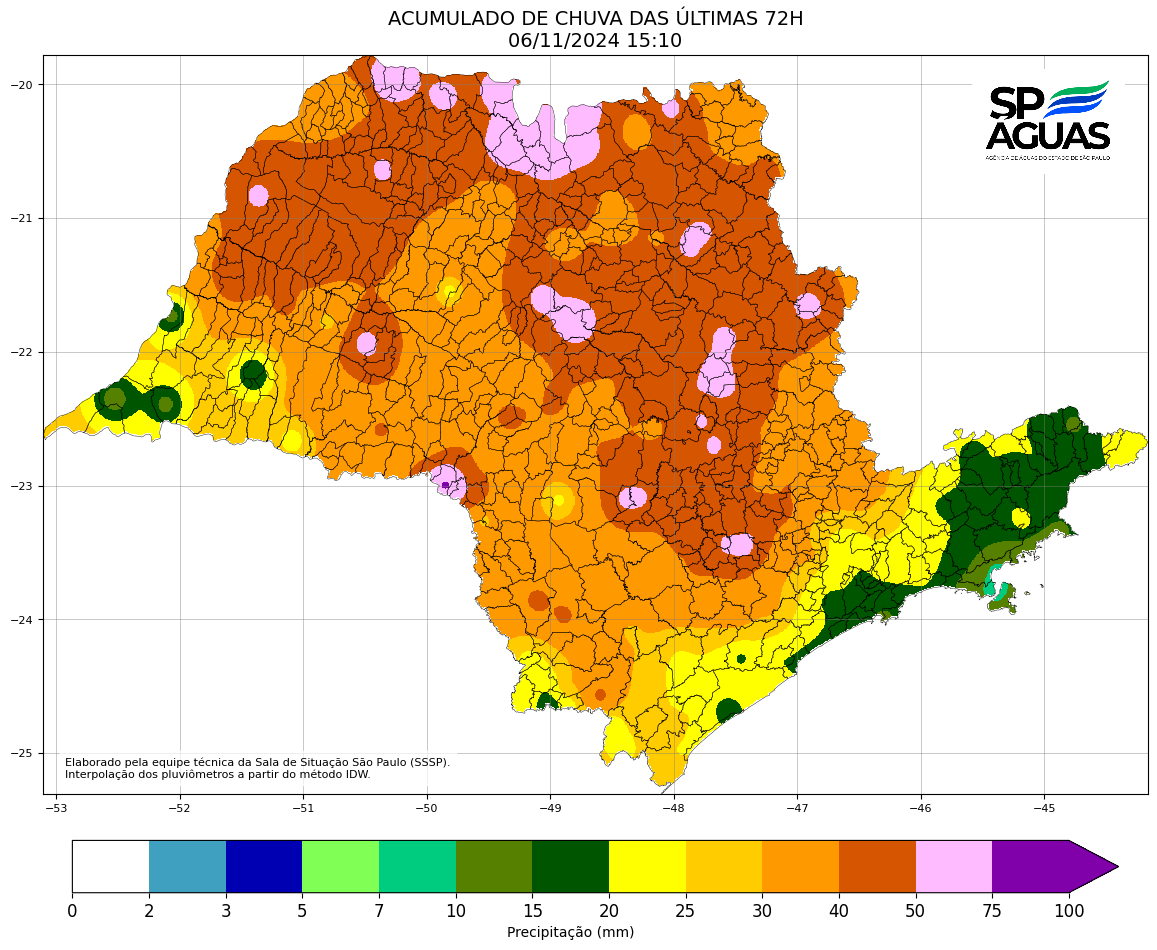

In [3]:
import geopandas as gpd
from osgeo import gdal, ogr, osr
import requests
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from datetime import datetime, timedelta
import os

# Perguntar ao usuário se deseja excluir alguma estação por prefixo
excluir_prefixos = input(
    "Digite os prefixos das estações a serem excluídas (separados por vírgula), ou pressione Enter para continuar: "
).strip()
excluir_prefixos = [prefix.strip() for prefix in excluir_prefixos.split(",")] if excluir_prefixos else []

def gerar_mapa_chuva(url, titulo, excluir_prefixos):
    # Carregando a fronteira do estado de São Paulo e criando um shapefile temporário
    sp_border = gpd.read_file('/content/drive/MyDrive/dados/DIV_MUN_IGC_SP_2021/DIV_MUN_SP_2021a.shp').to_crs(epsg=4326)
    minx, miny, maxx, maxy = sp_border.total_bounds

    sp_border_shapefile = "sp_border.shp"
    sp_border.to_file(sp_border_shapefile)

    # Obtendo dados da API
    response = requests.get(url)
    data = response.json()

    # Extraindo coordenadas e valores
    stations = [
        (item["prefix"], float(item["latitude"]), float(item["longitude"]), item["value"])
        for item in data["json"]
        if item["latitude"] and item["longitude"] and item["value"]
    ]

    # Filtrando estações
    filtered_stations = [
        (lat, lon, value)
        for prefix, lat, lon, value in stations
        if prefix not in excluir_prefixos
    ]

    if not filtered_stations:
        print("Erro: Não há dados válidos para interpolação após a exclusão.")
        return

    # Separando latitudes, longitudes e valores
    lats, longs, values = zip(*filtered_stations)

    # Salvando os pontos em um shapefile temporário
    shapefile_path = "temp_points.shp"
    driver = ogr.GetDriverByName("ESRI Shapefile")
    dataSource = driver.CreateDataSource(shapefile_path)
    layer = dataSource.CreateLayer("layer", geom_type=ogr.wkbPoint)

    # Adicionando valores de precipitação
    layer.CreateField(ogr.FieldDefn("value", ogr.OFTReal))
    for lat, lon, value in zip(lats, longs, values):
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(lon, lat)
        feature = ogr.Feature(layer.GetLayerDefn())
        feature.SetGeometry(point)
        feature.SetField("value", value)
        layer.CreateFeature(feature)
        feature = None

    dataSource = None  # Fechando o shapefile

    # Interpolação IDW usando GDAL com recorte por clipsrclayer

    """
    POWER
Igual a 2 é aconselhado na literatura

    SMOOTHING
Valores baixos (0.0 - 0.1): Mantêm os dados muito próximos ao valor real observado nas estações, o que resulta em uma interpolação mais "pontuda".
                            Isso é adequado se as estações estiverem muito próximas e os dados forem bastante consistentes.
Valores médios (0.2 - 1.0): Um valor de smoothing na faixa de 0.2 a 0.5 geralmente funciona bem para dados pluviométricos, especialmente quando as
                            estações estão razoavelmente espaçadas e você deseja suavizar gradualmente as variações. Esse intervalo ainda preserva o detalhe dos dados,
                            mas atenua picos extremos.
Valores altos (1.0 e acima): Resultam em uma interpolação muito mais suave, sendo útil apenas se você tiver uma rede de medição esparsa ou estiver mais interessado
                              na tendência geral do que nos detalhes locais.

    RADIUS
Valores em graus, a cada 10km equivale 0.09

    """

    output_raster = "output_idw.tif"
    gdal.Grid(
        output_raster,
        shapefile_path,
        zfield="value",
        algorithm="invdist:power=2.0:smoothing=0.1:radius=10",
        outputBounds=(minx, miny, maxx, maxy),
        width=1000, height=1000,
    )

    # Verificação de criação do raster intermediário
    if not os.path.exists(output_raster):
        print(f"Erro: O raster intermediário {output_raster} não foi criado.")
        return
    else:
        print(f"Raster intermediário {output_raster} criado com sucesso.")

    # Definindo sistema de coordenadas EPSG:4326 no raster
    raster = gdal.Open(output_raster, gdal.GA_Update)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    raster.SetProjection(srs.ExportToWkt())
    raster = None  # Salva e fecha o raster para confirmar a projeção

    # Aplicando o recorte do raster usando o polígono da fronteira de São Paulo
    cropped_raster = "output_idw_cropped.tif"
    gdal.Warp(
        cropped_raster,
        output_raster,
        cutlineDSName=sp_border_shapefile,  # Define o shapefile para o recorte
        cropToCutline=True,
        dstNodata=np.nan,
    )

    # Verificação de criação do raster recortado
    if not os.path.exists(cropped_raster):
        print("Erro: O raster recortado não pôde ser criado.")
        return
    else:
        print("Raster recortado criado com sucesso.")

    # Plot do resultado
    fig, ax = plt.subplots(figsize=(18, 12))

    # Carregar e plotar o raster recortado
    raster = gdal.Open(cropped_raster)
    if raster is None:
        print("Erro: O raster recortado não pôde ser aberto.")
        return

    raster_data = raster.ReadAsArray()

    # Definindo o colormap e os intervalos de valores
    cmap = ListedColormap([
        "#ffffff00", "#0080aabf", "#0000B3", "#80FF55", "#00CC7F",
        "#558000", "#005500", "#FFFF00", "#FFCC00", "#FF9900",
        "#D55500", "#FFBBFF", "#FF2B80", "#8000AA"
    ])

    bounds = [0, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100]
    norm = BoundaryNorm(bounds, cmap.N)


    img = ax.imshow(raster_data, cmap=cmap, extent=(minx, maxx, miny, maxy), norm=norm)

    sp_border.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.3)


    # Adicionando legenda e logo
    # Adicionando a colorbar com um tamanho de fonte maior para os números
    cbar = fig.colorbar(img, ax=ax, orientation="horizontal", label="Precipitação (mm)", shrink=0.75, pad=0.05, extend='max')
    cbar.set_ticks(bounds)  # Define os ticks em cada valor do intervalo
    cbar.set_ticklabels([str(b) for b in bounds])
    cbar.ax.tick_params(labelsize=12)  # Ajuste o valor para o tamanho da fonte desejado

    #fig.colorbar(img, ax=ax, orientation="horizontal", label="Precipitação (mm)", shrink=0.8, pad=0.05, extend='max')

    logo_path = "/content/drive/MyDrive/dados/logo.png"
    if os.path.exists(logo_path):

      logo = Image.open(logo_path)
      imagebox = OffsetImage(logo, zoom=0.2)

      ab = AnnotationBbox(
          imagebox,
          (0.91, 0.91),
          xycoords='axes fraction',
          frameon=True,
          bboxprops=dict(facecolor="white", edgecolor="none")
      )
      ax.add_artist(ab)
    else:
        print("Aviso: O logo não foi encontrado e não será exibido.")

    annotation_text = (
        "Elaborado pela equipe técnica da Sala de Situação São Paulo (SSSP).\n"
        "Interpolação dos pluviômetros a partir do método IDW."
    )

    ax.annotate(
        annotation_text, xy=(0.02, 0.02), xycoords='axes fraction',
        fontsize=8, ha='left', va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='white')
    )

    date = (datetime.now() - timedelta(hours=3)).strftime('%d/%m/%Y %H:%M')
    ax.set_title(f'{titulo}\n{date}', fontsize=14)
    ax.grid(which='both', linestyle='-', linewidth=0.5, color='gray', alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=8)

    plt.savefig(titulo, dpi=300, bbox_inches="tight")

    plt.show()

intervalos = [
    ("https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=1&show_all=true", "ACUMULADO DE CHUVA DA ÚLTIMA 1H"),
    ("https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=2&show_all=true", "ACUMULADO DE CHUVA DA ÚLTIMAS 2H"),
    ("https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=3&show_all=true", "ACUMULADO DE CHUVA DA ÚLTIMAS 3H"),
    ("https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=12&show_all=true", "ACUMULADO DE CHUVA DA ÚLTIMAS 12H"),
    ("https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=24&show_all=true","ACUMULADO DE CHUVA DAS ÚLTIMAS 24H"),
    ("https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=48&show_all=true", "ACUMULADO DE CHUVA DA ÚLTIMAS 48H"),
    ("https://cth.daee.sp.gov.br/sibh/api/v1/measurements/last_hours_events?hours=72&show_all=true", "ACUMULADO DE CHUVA DAS ÚLTIMAS 72H")
]


# Gerando mapas para cada intervalo
for url, titulo in intervalos:
    gerar_mapa_chuva(url, titulo, excluir_prefixos)